In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys

sys.path.append('../')

from implementations import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Load and clean the training data**

We load the training data.

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("../data")

print(f"The data has {x_train.shape[0]} samples and {x_train.shape[1]} features !")

The data has 328135 samples and 321 features !


We then clean the data by : 
- selecting the best 43 features with human decision and correlation analysis
- removing the nan values by the median of the rest of the feature for continuous values
- removing the nan values by the -1 for categorical features
- removing the features where the variance is zero since they are constants for all samples

In [3]:
feat = [20, 26, 27, 29, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 47, 48, 50, 57, 58, 61, 66, 69, 70, 
        71, 95, 100, 103, 108, 109, 138, 144, 157, 230, 231, 232, 234, 238, 248, 253, 257, 258, 304]

feat_cat = [20, 26, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 47, 48, 50, 57, 58, 61, 66, 69, 
            70, 71, 95, 100, 103, 108, 109, 138, 144, 157, 230, 231, 232, 234, 238, 257, 258]

feat_con = [27, 29, 248, 253, 304]

In [4]:
xt_feat = x_train
xt_feat = preprocessing(x_train)
xt_feat = gen_clean(x_train, feat_cat, feat_con)
xt_feat = x_train[:, feat]
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 43 features !


In [5]:
xt_feat = x_train
xt_feat = preprocessing(x_train)
xt_feat = gen_clean(xt_feat, [], np.arange(321))
print(f"The data has now {xt_feat.shape[1]} features !")

The data has now 321 features !


In [6]:
x_train_pca = xt_feat

# PCA algorithm implementation

In [6]:
pca_indices, idx = pca(xt_feat)
print(f"We can keep the {idx} first most influent features given by pca_indices")

We can keep the 128 first most influent features given by pca_indices


In [7]:
x_train_pca = xt_feat[:, pca_indices]
x_train_pca = xt_feat[:, :idx]

print(f"The data has now {x_train_pca.shape[1]} features")

The data has now 128 features


# Ridge regression

We find the Ridge regression solutions using the normal equations.

First, we separate our data in a training set (70%) and testing set (30%).

In [8]:
tx_tr, tx_te, y_tr, y_te = cross(x_train_pca, y_train, 0.8)

print(f"tx_tr shape : {tx_tr.shape} ; tx_te shape : {tx_te.shape}")
print(f"       y_tr : {y_tr.shape}     ;        y_te : {y_te.shape}")

tx_tr shape : (262508, 128) ; tx_te shape : (65627, 128)
       y_tr : (262508,)     ;        y_te : (65627,)


Now we build our models for linear regression

In [9]:
y, tx = build_model_data(tx_tr, y_tr)
y_test, tx_test = build_model_data(tx_te, y_te)
print(f"The data has now {tx.shape[1]} features !")

The data has now 129 features !


## Linear regression using ridge regression

Here we train our model using ridge regression with normal equations

In [10]:
start_time = datetime.datetime.now()

degrees = np.arange(2, 5)
lambdas = np.logspace(-4, 0, 30)

best_degree, best_lambda, best_rmse = best_degree_selection(y, tx, degrees, 4, lambdas)

end_time = datetime.datetime.now()

print(
    "The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f."
    % (best_rmse, best_degree, best_lambda)
)

print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Degree 2 done !
Degree 3 done !
Degree 4 done !
The best rmse of 0.548 is obtained for a degree of 2 and a lambda of 0.01610.
Execution time 2567.75987 seconds


In [10]:
best_degree = 2
best_lambda = 0.01610

tx_tr = build_poly(tx, best_degree)
tx_te_poly = build_poly(tx_test, best_degree)

w, loss = ridge_regression(y, tx_tr, best_lambda)

In [21]:
print(tx_tr.shape)
print(tx_te_poly.shape)

(262508, 259)
(65627, 259)


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)



In [11]:
best_f = 0
best_tresh = -100

for el in np.linspace(-1,1,1000): 
    pred_data = np.dot(tx_tr, w)

    pred_data[pred_data > el] = 1
    pred_data[pred_data <= el] = -1

    tp = np.sum((pred_data == 1) & (y == 1))
    fp = np.sum((pred_data == 1) & (y == -1))

    tn = np.sum((pred_data == -1) & (y == -1))
    fn = np.sum((pred_data == -1) & (y == 1))
    
    f_one = tp/(tp + 0.5*(fn + fp))
    
    if (f_one > best_f):
        best_f = f_one
        best_tresh = el

print(best_tresh)
print(f"F1-score : {best_f}%")

-0.5955955955955956
F1-score : 0.40619951696230067%


In [12]:
pred_data = np.dot(tx_tr, w)

pred_data[pred_data > best_tresh] = 1
pred_data[pred_data < best_tresh] = -1

correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == -1))

tn = np.sum((pred_data == -1) & (y == -1))
fn = np.sum((pred_data == -1) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 85.85757386441556%
Precision: 32.21779615862786%
Recall : 54.95066643586637%
F1-score : 40.61995169623007%


Now we compute some metrics for our test data (40% of the total data)

In [13]:
pred_test = np.dot(tx_te_poly, w)

pred_test[pred_test > best_tresh] = 1
pred_test[pred_test < best_tresh] = -1

correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == -1))

tn = np.sum((pred_test == -1) & (y_test == -1))
fn = np.sum((pred_test == -1) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"Precision: {tp/(tp + fp)*100}%")
print(f"Recall : {tp/(tp + fn)*100}%")
print(f"F1-score : {tp/(tp + 0.5*(fn + fp))*100}%")

Accuracy: 85.87014490986942%
Precision: 32.87064976865822%
Recall : 55.70138060337481%
F1-score : 41.34353849073313%


### Feature analysis

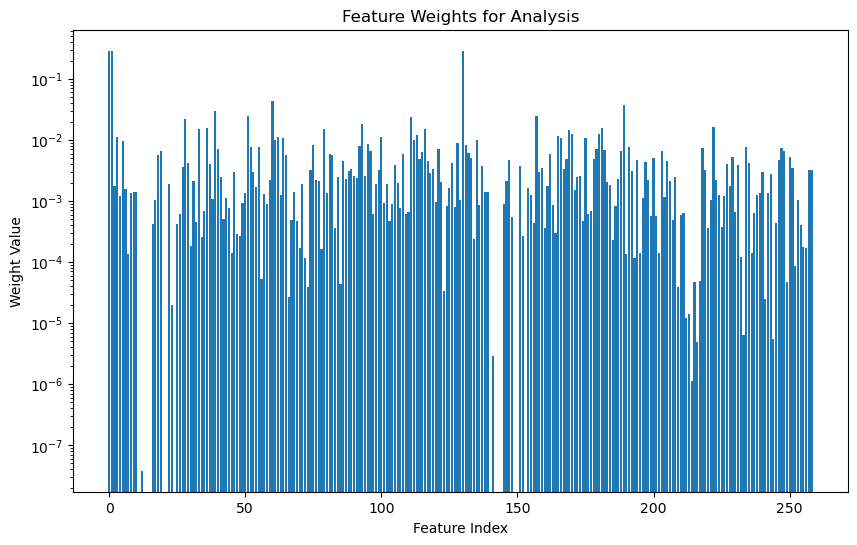

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

# **Prediction on test data**

In [22]:
start_time = datetime.datetime.now()

tx_test = x_test
tx_test = preprocessing(x_test)
tx_test = gen_clean(tx_test, [], np.arange(321))

tx_test = tx_test[:, pca_indices]
tx_test = tx_test[:, :idx]
tx_test = np.c_[np.ones(tx_test.shape[0]), tx_test]

tx_test = build_poly(tx_test, best_degree)

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")
print(f"The data has {tx_test.shape[0]} samples and {tx_test.shape[1]} features !")

Execution time 3.531589 seconds
The data has 109379 samples and 259 features !


In [23]:
pred_te = np.dot(tx_test, w)

pred_te[pred_te > best_tresh] = 1
pred_te[pred_te < best_tresh] = -1

indices_one = np.where(pred_te == 1)

In [24]:
create_csv_submission(test_ids, pred_te, "../data/ridge_reg.csv")